In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [3]:
resnet_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 12.8MB/s]


In [4]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
     transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
 

]) 

In [5]:
train_data = datasets.ImageFolder(root="/kaggle/input/chest-ctscan-images/Data/train",
                                  transform=data_transform, 
                                  target_transform=None) 

test_data = datasets.ImageFolder(root="/kaggle/input/chest-ctscan-images/Data/test",
                                 transform=data_transform)


validation_data = datasets.ImageFolder(root="/kaggle/input/chest-ctscan-images/Data/valid",
                                 transform=data_transform)
train_data, test_data ,validation_data

(Dataset ImageFolder
     Number of datapoints: 613
     Root location: /kaggle/input/chest-ctscan-images/Data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.7)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 315
     Root location: /kaggle/input/chest-ctscan-images/Data/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.7)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 72
     Root location: /kaggle/input/chest-ctscan-images/Data/valid
   

In [6]:
train_data[np.random.randint(0 , len(train_data))]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 3)

In [7]:
len(train_data), len(test_data)

(613, 315)

In [8]:
class_names = train_data.classes
class_names

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [9]:
class_dict = train_data.class_to_idx
class_dict

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [10]:
old_key1 = 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
new_key1 = 'adenocarcinoma_left.lower.lobe'

old_key2 = 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
new_key2 = 'large.cell.carcinoma_left.hilum'

old_key3 = 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
new_key3 = 'squamous.cell.carcinoma_left.hilum'

class_dict[new_key1] = class_dict[old_key1]
class_dict[new_key2] = class_dict[old_key2]
class_dict[new_key3] = class_dict[old_key3]

del class_dict[old_key1]
del class_dict[old_key2]
del class_dict[old_key3]

print(class_dict)

{'normal': 2, 'adenocarcinoma_left.lower.lobe': 0, 'large.cell.carcinoma_left.hilum': 1, 'squamous.cell.carcinoma_left.hilum': 3}


In [11]:
class_names[0]=new_key1
class_names[1]=new_key2
class_names[3]=new_key3
class_names

['adenocarcinoma_left.lower.lobe',
 'large.cell.carcinoma_left.hilum',
 'normal',
 'squamous.cell.carcinoma_left.hilum']

In [12]:
len(train_data), len(test_data)

(613, 315)

In [13]:
random_idx = torch.randint(0, len(train_data), size=(1,)).item()
img, label = train_data[random_idx][0], train_data[random_idx][1]

Image permute: torch.Size([224, 224, 3]) 


Text(0.5, 1.0, 'squamous.cell.carcinoma_left.hilum')

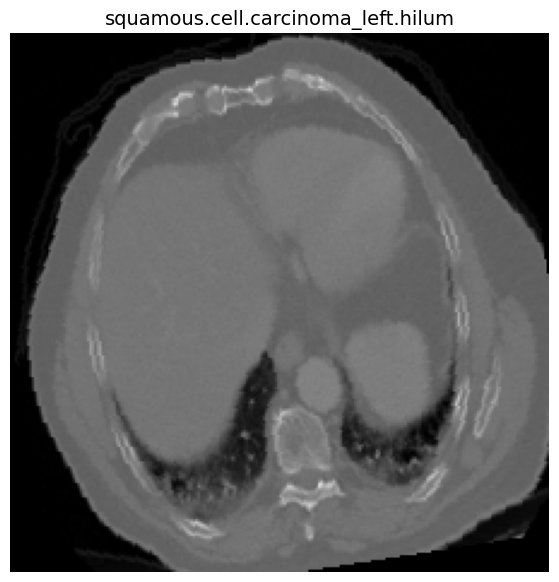

In [14]:
import random 
from PIL import Image
import matplotlib.pyplot as plt
random_idx = torch.randint(0, len(train_data), size=(1,)).item()
img, label = train_data[random_idx][0], train_data[random_idx][1]


img_permute = img.permute(1, 2, 0)
print(f"Image permute: {img_permute.shape} ")
plt.figure(figsize=(12, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [15]:
BATCH_SIZE=32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c815465e590>,
 <torch.utils.data.dataloader.DataLoader at 0x7c815462c210>)

In [16]:
resnet_model.fc = nn.Sequential (
    nn.Linear(512,512),
    nn.Dropout(0.2),
     nn.Linear(512,256),
    nn.Linear(256,len(class_names)), # -> len(labels) labels according to labels
)
resnet_model.fc

Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): Linear(in_features=256, out_features=4, bias=True)
)

In [17]:
resnet_model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [18]:
from torch.optim import lr_scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=0.01, momentum=0.9)

In [19]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X) 


    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

  
    optimizer.zero_grad()

    
    loss.backward()

  
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
  
  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader) 
  return train_loss, train_acc 

In [20]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0,  0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader): 
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

     
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

    
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [21]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5, 
          device=device):
  
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  return results

In [22]:
NUM_EPOCHS = 15

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Move the model to the device (VERY IMPORTANT)
resnet_model = resnet_model.to(device)

# Now train the model
model_0_results = train(model=resnet_model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0738 | Train acc: 0.5269 | Test loss: 1.9346 | Test acc: 0.3426
Epoch: 1 | Train loss: 0.6587 | Train acc: 0.7291 | Test loss: 0.8862 | Test acc: 0.5784
Epoch: 2 | Train loss: 0.3843 | Train acc: 0.8766 | Test loss: 0.8962 | Test acc: 0.7028
Epoch: 3 | Train loss: 0.4985 | Train acc: 0.7934 | Test loss: 1.5754 | Test acc: 0.3961
Epoch: 4 | Train loss: 0.4379 | Train acc: 0.8344 | Test loss: 0.5702 | Test acc: 0.7763
Epoch: 5 | Train loss: 0.2345 | Train acc: 0.9103 | Test loss: 1.4007 | Test acc: 0.6984
Epoch: 6 | Train loss: 0.2901 | Train acc: 0.9047 | Test loss: 0.6318 | Test acc: 0.7584
Epoch: 7 | Train loss: 0.1839 | Train acc: 0.9281 | Test loss: 0.4529 | Test acc: 0.8389
Epoch: 8 | Train loss: 0.1855 | Train acc: 0.9331 | Test loss: 0.4987 | Test acc: 0.8321
Epoch: 9 | Train loss: 0.1591 | Train acc: 0.9453 | Test loss: 0.6817 | Test acc: 0.7858
Epoch: 10 | Train loss: 0.1888 | Train acc: 0.9619 | Test loss: 0.3703 | Test acc: 0.8719
Epoch: 11 | Train lo

In [23]:
torch.save(resnet_model.state_dict(), "chest_cancer_model.pth")

In [24]:
import torchvision
print(f"numpy version: {np.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"matplotlib version: {plt.matplotlib.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

numpy version: 1.26.4
seaborn version: 0.12.2
matplotlib version: 3.7.5
pandas version: 2.2.3
torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124
scikit-learn version: 1.2.2
